In [1]:
import deepdish as dd
import os
import numpy as np
import pylab as plt
import seaborn as sns
import h5py
import pandas as pd
from astropy.cosmology import Planck18 as cosmo
from glob import glob

In [7]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import sys
sys.path.append('../')
import detectors, detector_psds

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
data_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'

## Combine Data

### BNS

In [51]:
data_parts_files = glob(os.path.join(data_dir, 'simple_pe*','*part*.h5'))

total_data_dir = {}
data = dd.io.load(data_parts_files[0])
for key in data.keys():
    total_data_dir[key] = {}
    for param in data[key]:
        total_data_dir[key][param] = data[key][param]

for file in data_parts_files[1:]:
    data = dd.io.load(file)
    for key in data.keys():
        for param in data[key]:
            total_data_dir[key][param] = np.append(total_data_dir[key][param], data[key][param])
            
dd.io.save(os.path.join(data_dir, 'simple_pe_output_files', 'LHI_loc_results_1_pop_PL_spin_AU_z_MD_zmax_2_lmrd_106_366_days_corrected_td_combined.h5'), total_data_dir)

### NSBH

In [96]:
data_parts_files = glob(os.path.join(data_dir, 'SNR*', 'NSBH', '*part*.h5'))

total_data_dir = {}
data = dd.io.load(data_parts_files[0])
total_data_dir['config'] = data['config']

total_data_dir['Optimal_SNR'] = {}
for param in data['Optimal_SNR']:
    total_data_dir['Optimal_SNR'][param] = data['Optimal_SNR'][param]

for file in data_parts_files[1:]:
    data = dd.io.load(file)
    for param in data['Optimal_SNR']:
        total_data_dir['Optimal_SNR'][param] = np.append(total_data_dir['Optimal_SNR'][param], data['Optimal_SNR'][param])
total_data_dir['Optimal_SNR'] = pd.DataFrame(total_data_dir['Optimal_SNR'])
            
dd.io.save(os.path.join(data_dir, 'SNR_output_files', 'NSBH', 'LHI_SNR_1_pop_US_spin_prec_z_MD_zmax_2_lmrd_45_305_days_corrected_td_SNR_data_combined.h5'), total_data_dir)

/home/divyajyoti/miniconda3/envs/pycbc_pip/lib/python3.11/site-packages/tables/attributeset.py:462: NaturalNameWarning: object name is not a valid Python identifier: 'mass-model'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/divyajyoti/miniconda3/envs/pycbc_pip/lib/python3.11/site-packages/tables/attributeset.py:462: NaturalNameWarning: object name is not a valid Python identifier: 'mass-parameters'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/divyajyoti/miniconda3/envs/pycbc_pip/lib/python3.11/site-packages/tables/attributeset.py:462: NaturalNameWarning: object name is not a valid Python identifier: 'gps-start-time'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_

In [102]:
total_data_dir

{'config': {'Extrinsic': {},
  'Mass': {'mass-model': np.str_('UniformSecondary'),
   'mass-parameters': np.str_("{'alpha':3.37, 'beta': 0.76, 'delta_m':5.23, 'mmin':4.89, 'mmax':88.81, 'lam':0.04, 'mpp': 33.60, 'sigpp':4.59, 'minimum_secondary_mass': 1.0 , 'maximum_secondary_mass': 2.0}")},
  'Redshift': {'cosmology': np.str_('Planck18'),
   'duration': np.str_('5270400'),
   'gps-start-time': np.str_('1893024018'),
   'local-merger-rate-density': np.str_('45'),
   'maximum-redshift': np.str_('2'),
   'redshift-model': np.str_('MadauDickinson'),
   'redshift-parameters': np.str_('{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}')},
  'Spin': {'spin-model': np.str_('Isotropic-Bilby'),
   'spin-parameters': np.str_("{'minimum_primary_spin' : 0, 'maximum_primary_spin':  0.99, 'minimum_secondary_spin' : 0, 'maximum_secondary_spin' : 0.1}")}},
 'Optimal_SNR':        PSD_L1  PSD_H1  PSD_I1   spin1_a   spin2_a   chi_eff     chi_p  \
 0      ASharp  ASharp  ASharp  0.818534  0.089484 -0.597136  0.

## Function definitions

In [10]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, method='network', return_detected_dict=False):
    SNR_keys = [key for key in data_dict.keys() if 'SNR' in key]
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        dict_key = key.split('SNR_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [11]:
def bin_style(hist_data):
    if len(hist_data)>100:
        bs = 'sqrt'
    else:
        if len(hist_data)>50:
            bs = 'auto'
        else:
            bs = len(hist_data)//3
            if bs==0:
                bs=1
    return(bs)

In [12]:
def plot_efficiency_curve(selected_data, total_data, bins='sqrt', **kwargs):
    ns_sel, bins_sel = np.histogram(selected_data, bins=bins)
    ns_tot, bins_tot = np.histogram(total_data, bins=bins_sel)
    if not np.all(bins_sel == bins_tot):
        raise ValueError("Bins are not equal! Something went wrong.")
    eff_samples = ns_sel/ns_tot
    #plt.bar(bins_sel[:-1], eff_samples, np.diff(bins_sel), **kwargs)
    
    # Using plt.step to create a step-like plot
    line = plt.stairs(eff_samples, bins_sel, **kwargs)
    return(eff_samples, bins_sel)

## BBH

In [13]:
data_dir_bbh = os.path.join(data_dir, 'SNR_output_files', 'BBH')

In [18]:
with h5py.File(data_file[0], 'r') as f:
    print(f['Optimal_SNR'].keys())

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values', 'block2_items', 'block2_values']>


In [14]:
data_file = glob(os.path.join(data_dir_bbh, '*.h5'))
print(data_file)
bbh_data = dd.io.load(data_file[0])
snr_data_bbh = bbh_data['Optimal_SNR']
snr_data_bbh['comoving_distance'] = cosmo.comoving_distance(snr_data_bbh['redshift'])
config_bbh = bbh_data['config']

['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/SNR_output_files/BBH/LHI_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td_SNR_data.h5']


In [16]:
bbh_data['Optimal_SNR'].keys()

Index(['PSD_L1', 'PSD_H1', 'PSD_I1', 'spin1_a', 'spin2_a', 'chi_eff', 'chi_p',
       'mchirp', 'srcmchirp', 'cos_spin1_polar', 'cos_spin2_polar', 'srcmass1',
       'srcmass2', 'q', 'spin1_azimuthal', 'spin2_azimuthal', 'redshift',
       'eta', 'spin1_polar', 'spin2_polar', 'mtotal', 'srcmtotal',
       'chi_1_in_plane', 'chi_2_in_plane', 'phi_12', 'phi_jl', 'theta_jn',
       'time_interval', 'inclination', 'distance', 'mass1', 'mass2',
       'coa_phase', 'f_ref', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y',
       'spin2z', 'approximant', 'f_lower', 'delta_f', 'f_final', 'dec',
       'trigger_time', 'polarization', 'ra', 'SNR_L1', 'SNR_H1', 'SNR_I1',
       'SNR_network', 'comoving_distance'],
      dtype='object')

In [10]:
detected_bbh = {'all':{}, 'network':{}, 'two-detector':{}}
for method in detected_bbh.keys():
    detected_bbh[method] = get_detected_SNRs(snr_data_bbh, method=method)

Text(0, 0.5, 'Events / year')

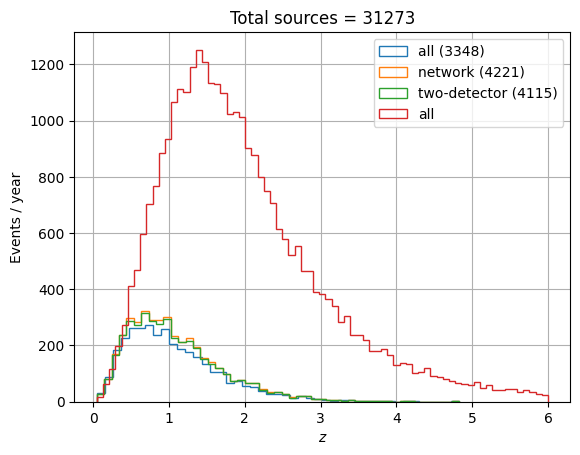

In [23]:
for key in detected_bbh.keys():
    bbh_data = detected_bbh[key]
    plt.hist(bbh_data['redshift'], histtype=u'step', 
             label=f'{key} ({len(bbh_data["redshift"])})', bins='auto')
plt.hist(snr_data_bbh['redshift'], histtype=u'step', label='all', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bbh["mass1"])}')
plt.grid()
plt.xlabel('$z$')
plt.ylabel('Events / year')

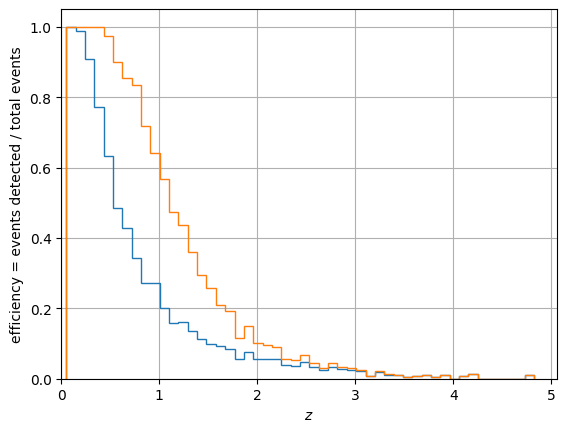

In [22]:
vals = plot_efficiency_curve(detected_bbh['two-detector']['redshift'], snr_data_bbh['redshift'], bins=50, zorder=2)
vals = plot_efficiency_curve(detected_bbh['two-detector']['redshift'][mass_cut], 
                             snr_data_bbh['redshift'][mass_cut_total], bins=50, zorder=2)
#plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$')
plt.ylabel('efficiency = events detected / total events')
plt.grid()

In [20]:
mass_cut = detected_bbh['two-detector']['mtotal']>50
mass_cut_total = snr_data_bbh['mtotal'] >50

/tmp/ipykernel_20549/522570130.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


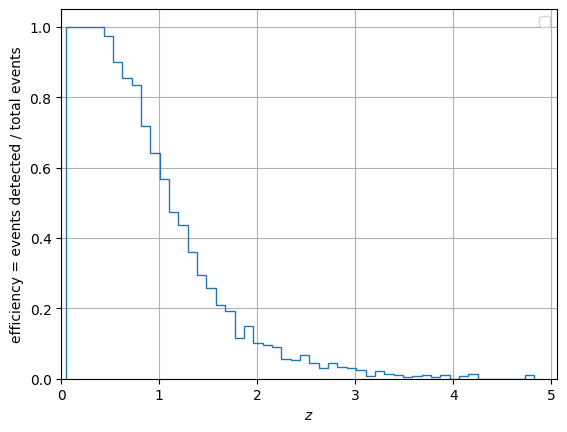

In [21]:
vals = plot_efficiency_curve(detected_bbh['two-detector']['redshift'][mass_cut], 
                             snr_data_bbh['redshift'][mass_cut_total], bins=50, zorder=2)
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$')
plt.ylabel('efficiency = events detected / total events')
plt.grid()

### Mass populations

In [13]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [14]:
detect_type = 'two-detector'
mass_pops_bbh = {}

for m_range in ['<10', '10-30', '30-70', '>70']:
    mass_pops_bbh[m_range] = {}
    for pop, input_dfs_dict in zip(['detected', 'total'], [detected_bbh[detect_type], snr_data_bbh]):
        mass_pops_bbh[m_range][pop] = {}
        for netw in input_dfs_dict.keys():
            bool_arr = slice_mtotal_pop(input_dfs_dict['srcmtotal'], m_range)
            mass_pops_bbh[m_range][pop] = input_dfs_dict[bool_arr]

In [15]:
input_dfs_dict.keys()

Index(['PSD_L1', 'PSD_H1', 'PSD_I1', 'spin1_a', 'spin2_a', 'chi_eff', 'chi_p',
       'mchirp', 'srcmchirp', 'cos_spin1_polar', 'cos_spin2_polar', 'srcmass1',
       'srcmass2', 'q', 'spin1_azimuthal', 'spin2_azimuthal', 'redshift',
       'eta', 'spin1_polar', 'spin2_polar', 'mtotal', 'srcmtotal',
       'chi_1_in_plane', 'chi_2_in_plane', 'phi_12', 'phi_jl', 'theta_jn',
       'time_interval', 'inclination', 'distance', 'mass1', 'mass2',
       'coa_phase', 'f_ref', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y',
       'spin2z', 'approximant', 'f_lower', 'delta_f', 'f_final', 'dec',
       'trigger_time', 'polarization', 'ra', 'SNR_L1', 'SNR_H1', 'SNR_I1',
       'SNR_network', 'comoving_distance'],
      dtype='object')

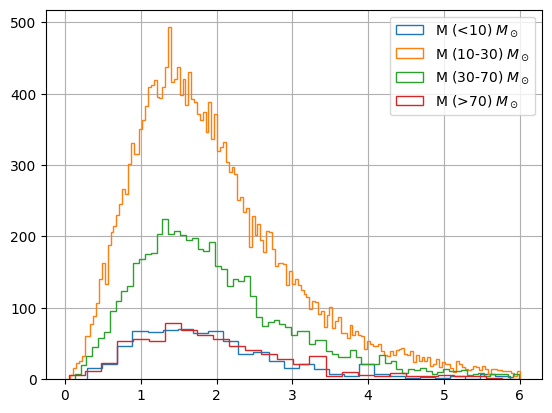

In [24]:
plt.figure()
for m_range, color in zip(mass_pops_bbh.keys(), colors):
    hist_data = mass_pops_bbh[m_range]['total']['redshift']
    plt.hist(hist_data, bins='sqrt', histtype=u'step', label='M ('+m_range+') $M_\odot$', color=color);
#plt.title(netw_labels[netw])
plt.legend()
plt.grid()

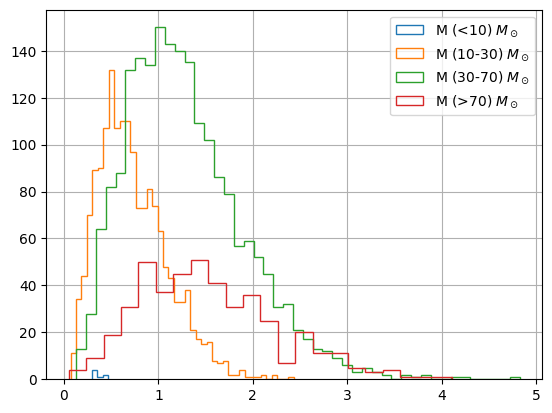

In [16]:
plt.figure()
for m_range, color in zip(mass_pops_bbh.keys(), colors):
    hist_data = mass_pops_bbh[m_range]['detected']['redshift']
    plt.hist(hist_data, bins='sqrt', histtype=u'step', label='M ('+m_range+') $M_\odot$', color=color);
#plt.title(netw_labels[netw])
plt.legend()
plt.grid()

Text(0.5, 1.0, '30 < M < 70')

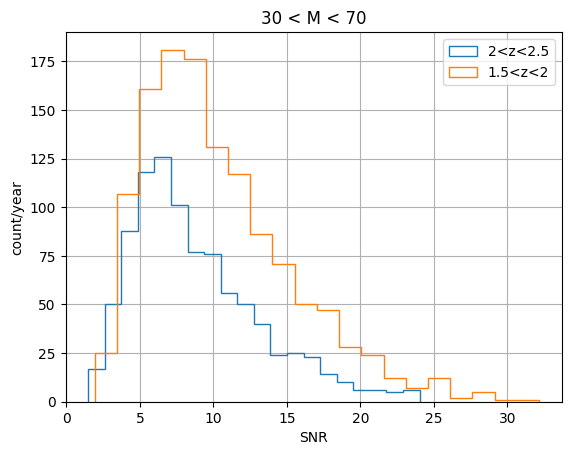

In [17]:
# This is first time we'll be seeing over the SFR peak with a few events which are detectable
plt.hist(mass_pops_bbh['30-70']['total']['SNR_network'][np.all((mass_pops_bbh['30-70']['total']['redshift'] < 2.5, 
                                                                      mass_pops_bbh['30-70']['total']['redshift'] > 2), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='2<z<2.5');
plt.hist(mass_pops_bbh['30-70']['total']['SNR_network'][np.all((mass_pops_bbh['30-70']['total']['redshift'] < 2, 
                                                                      mass_pops_bbh['30-70']['total']['redshift'] > 1.5), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='1.5<z<2');
plt.xlabel('SNR')
plt.grid()
plt.ylabel('count/year')
plt.legend()
plt.title('30 < M < 70')

In [18]:
plot_efficiency_curve(mass_pops_bbh['30-70']['detected']['redshift'])

{'detected':        PSD_L1  PSD_H1  PSD_I1   spin1_a   spin2_a   chi_eff     chi_p  \
 21     ASharp  ASharp  ASharp  0.722859  0.486068  0.294910  0.673684   
 54     ASharp  ASharp  ASharp  0.143704  0.089213  0.058219  0.113709   
 55     ASharp  ASharp  ASharp  0.552466  0.644969 -0.191465  0.508045   
 66     ASharp  ASharp  ASharp  0.174115  0.327616  0.086208  0.196443   
 68     ASharp  ASharp  ASharp  0.486907  0.049417  0.297976  0.188627   
 ...       ...     ...     ...       ...       ...       ...       ...   
 31199  ASharp  ASharp  ASharp  0.832638  0.387679  0.088846  0.795007   
 31210  ASharp  ASharp  ASharp  0.031140  0.307700 -0.014581  0.218144   
 31217  ASharp  ASharp  ASharp  0.066690  0.191901 -0.011229  0.174255   
 31240  ASharp  ASharp  ASharp  0.987772  0.369032 -0.194412  0.930768   
 31244  ASharp  ASharp  ASharp  0.468059  0.989246  0.099730  0.452873   
 
           mchirp  srcmchirp  cos_spin1_polar  ...  f_final       dec  \
 21     38.297251  19.267

/tmp/ipykernel_17358/1059002197.py:6: RuntimeWarning: invalid value encountered in divide
  eff_samples = ns_sel/ns_tot


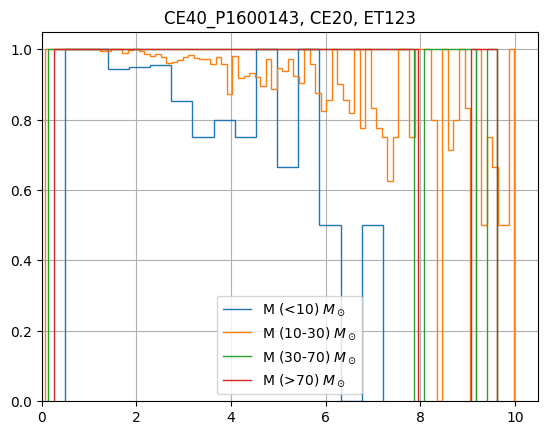

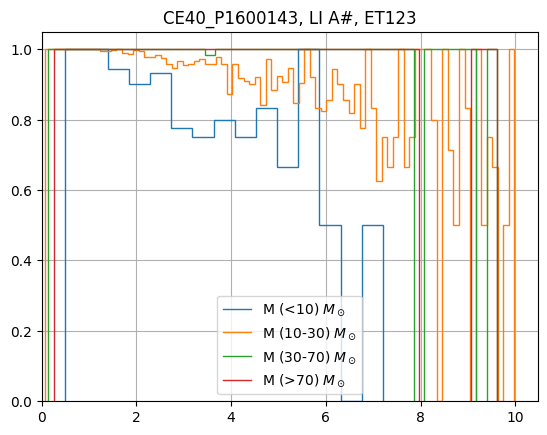

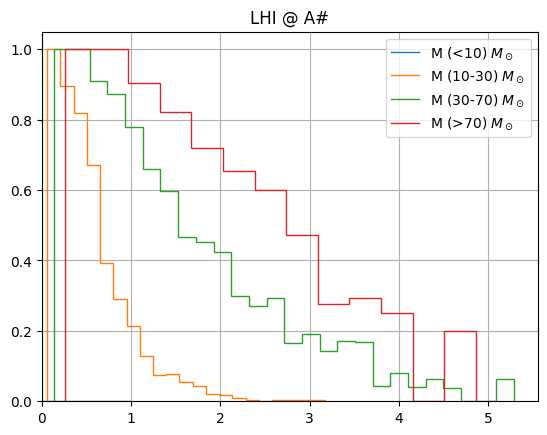

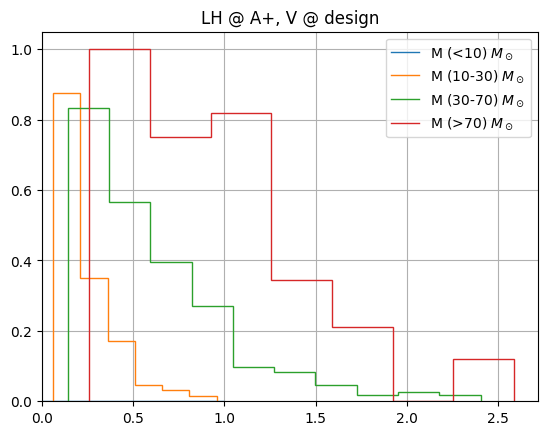

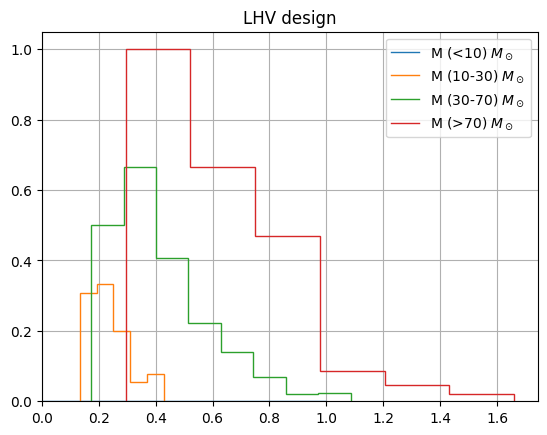

In [65]:
for netw in input_dfs_dict.keys():
    plt.figure()
    for m_range, color in zip(mass_pops_bbh.keys(), colors):
        hist_data_sel = mass_pops_bbh[m_range]['detected'][netw]['redshift']
        hist_data_tot = mass_pops_bbh[m_range]['total'][netw]['redshift']
        plot_efficiency_curve(hist_data_sel, hist_data_tot, bins='sqrt', label='M ('+m_range+') $M_\odot$', color=color, zorder=2);
    plt.title(netw_labels[netw])
    plt.legend()
    plt.xlim(0,)
    plt.grid()

## NSBH

In [104]:
data_dir_nsbh = os.path.join(data_dir, 'SNR_output_files', 'NSBH')

In [105]:
data_file = glob(os.path.join(data_dir_nsbh, '*combined*.h5'))
print(data_file)
nsbh_data = dd.io.load(data_file[0])
snr_data_nsbh = nsbh_data['Optimal_SNR']
snr_data_nsbh['comoving_distance'] = cosmo.comoving_distance(snr_data_nsbh['redshift'])
config_nsbh = nsbh_data['config']

['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/SNR_output_files/NSBH/LHI_SNR_1_pop_US_spin_prec_z_MD_zmax_2_lmrd_45_305_days_corrected_td_SNR_data_combined.h5']


In [106]:
detected_nsbh = {'all':{}, 'network':{}, 'two-detector':{}}
for method in detected_nsbh.keys():
    detected_nsbh[method] = get_detected_SNRs(snr_data_nsbh, method=method)

Text(0, 0.5, 'Events / year')

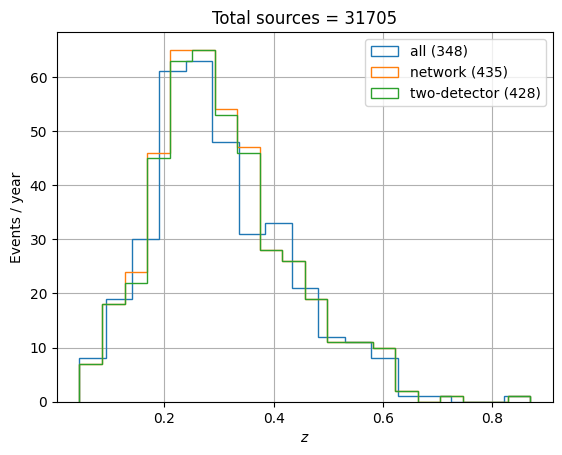

In [108]:
for key in detected_nsbh.keys():
    nsbh_data = detected_nsbh[key]
    plt.hist(nsbh_data['redshift'], histtype=u'step', 
             label=f'{key} ({len(nsbh_data["redshift"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_nsbh["mass1"])}')
plt.grid()
plt.xlabel('$z$')
plt.ylabel('Events / year')

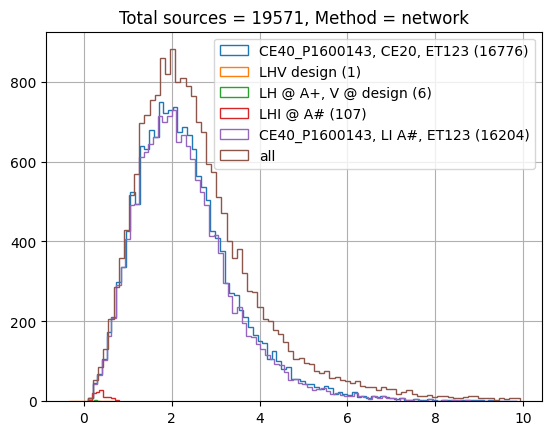

In [70]:
for key in detected_nsbh['network'].keys():
    nsbh_data = detected_nsbh['network'][key]
    plt.hist(nsbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(nsbh_data["redshift"])})', bins='auto')
plt.hist(snr_data_nsbh['CE40_P1600143_CE20ET123']['redshift'], histtype=u'step', label='all', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_nsbh["LHV_design"]["mass1"])}, Method = network')
plt.grid()

/tmp/ipykernel_17358/1059002197.py:6: RuntimeWarning: invalid value encountered in divide
  eff_samples = ns_sel/ns_tot


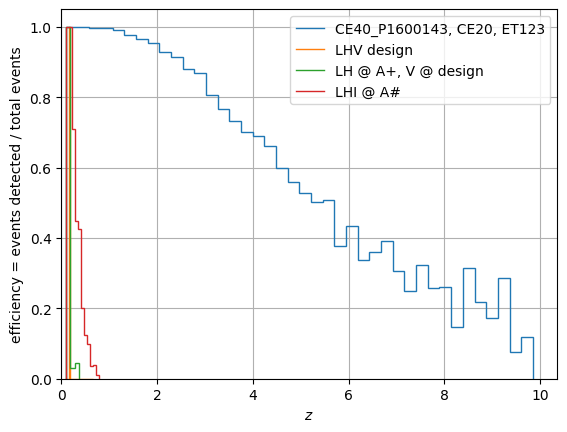

In [71]:
for netw, bns in zip(snr_data_nsbh.keys(), [40, 40, 'sqrt', 'sqrt']):
    vals = plot_efficiency_curve(detected_nsbh['network'][netw]['redshift'], snr_data_nsbh[netw]['redshift'], label=netw_labels[netw], bins=bns, zorder=2)
plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$')
plt.ylabel('efficiency = events detected / total events')
plt.grid()

## BNS

In [72]:
data_dir_bns = '../output_data/BNS/'

In [73]:
snr_data_bns = {}
config_bns = {}
for data_file in list(os.walk(data_dir_bns))[0][2]:
    key = data_file.split('_DG_')[0]
    bns_data = dd.io.load(os.path.join(data_dir_bns, data_file))
    snr_data_bns[key] = bns_data['Optimal_SNR']
    snr_data_bns[key]['comoving_distance'] = cosmo.comoving_distance(snr_data_bns[key]['redshift'])
    config_bns[key] = bns_data['config']

In [92]:
print('srcmchirp Mean:', np.mean(snr_data_bns['CE40_P1600143_LIAsharpET123']['srcmchirp']))
print('srcmchirp Std:', np.std(snr_data_bns['CE40_P1600143_LIAsharpET123']['srcmchirp']))

srcmchirp Mean: 1.2688649034774155
srcmchirp Std: 0.12486609612126023


In [74]:
detected_bns = {'all':{}, 'network':{}}
for key in snr_data_bns.keys():
    detected_bns['all'][key] = get_detected_SNRs(snr_data_bns[key], method='all')
    detected_bns['network'][key] = get_detected_SNRs(snr_data_bns[key], method='network')

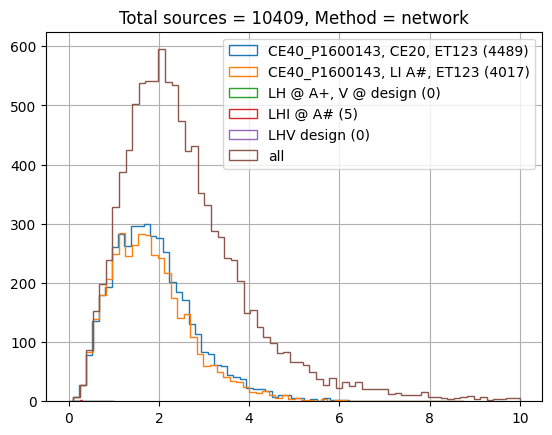

In [75]:
for key in detected_bns['network'].keys():
    bns_data = detected_bns['network'][key]
    plt.hist(bns_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bns_data["redshift"])})', bins='auto')
plt.hist(snr_data_bns['CE40_P1600143_CE20ET123']['redshift'], histtype=u'step', bins='auto', label='all')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bns["CE40_P1600143_LIAsharpET123"]["mass1"])}, Method = network')
plt.grid()

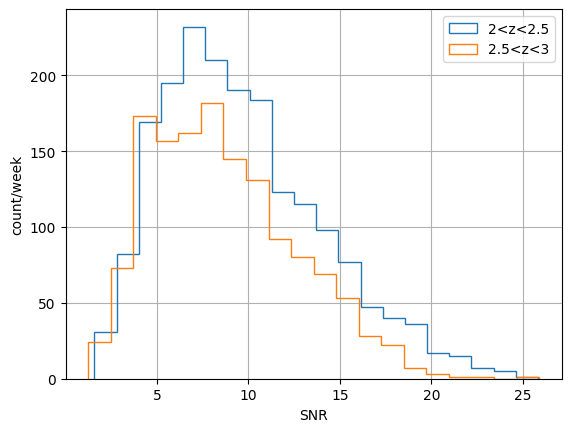

In [76]:
plt.hist(snr_data_bns['CE40_P1600143_CE20ET123']['SNR_network'][np.all((snr_data_bns['CE40_P1600143_CE20ET123']['redshift'] < 2.5, 
                                                                      snr_data_bns['CE40_P1600143_CE20ET123']['redshift'] > 2), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='2<z<2.5');
plt.hist(snr_data_bns['CE40_P1600143_CE20ET123']['SNR_network'][np.all((snr_data_bns['CE40_P1600143_CE20ET123']['redshift'] < 3, 
                                                                      snr_data_bns['CE40_P1600143_CE20ET123']['redshift'] > 2.5), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='2.5<z<3');
plt.xlabel('SNR')
plt.grid()
plt.ylabel('count/week')
plt.legend()
#plt.title('30 < M < 70')

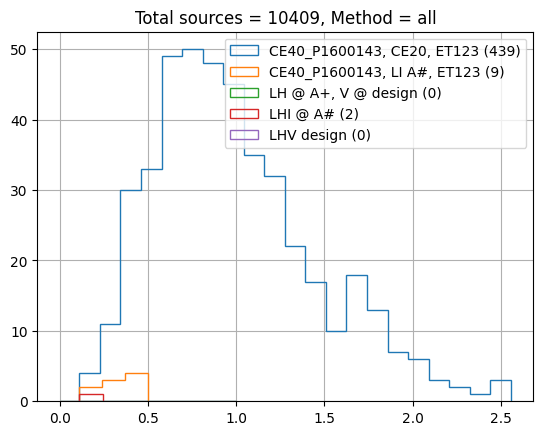

In [77]:
for key in detected_bns['all'].keys():
    bns_data = detected_bns['all'][key]
    plt.hist(bns_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bns_data["redshift"])})', bins='sqrt')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bns["CE40_P1600143_LIAsharpET123"]["mass1"])}, Method = all')
plt.grid()

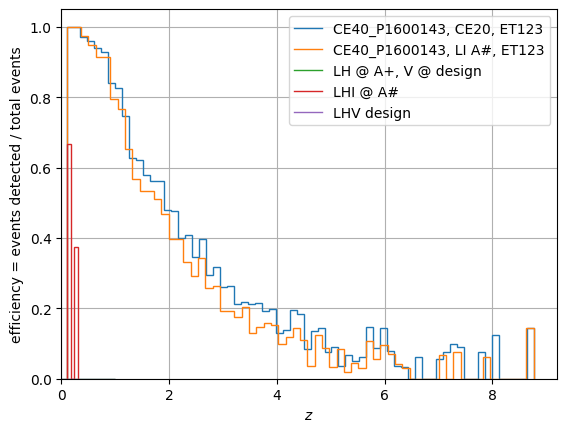

In [78]:
for netw in snr_data_bns.keys():
    vals = plot_efficiency_curve(detected_bns['network'][netw]['redshift'], snr_data_bns[netw]['redshift'], label=netw_labels[netw], zorder=2)
plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$')
plt.ylabel('efficiency = events detected / total events')
plt.grid()

## Efficiency curves comparison

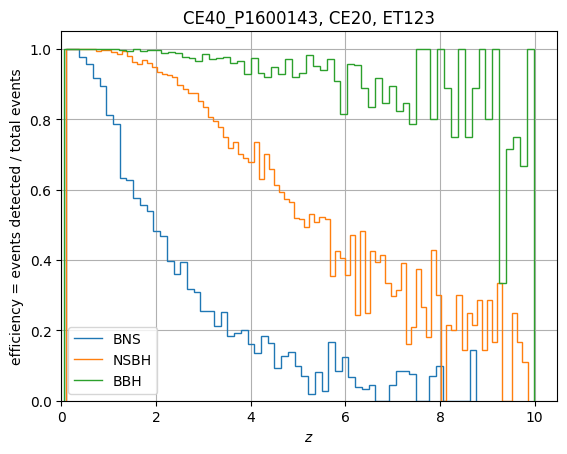

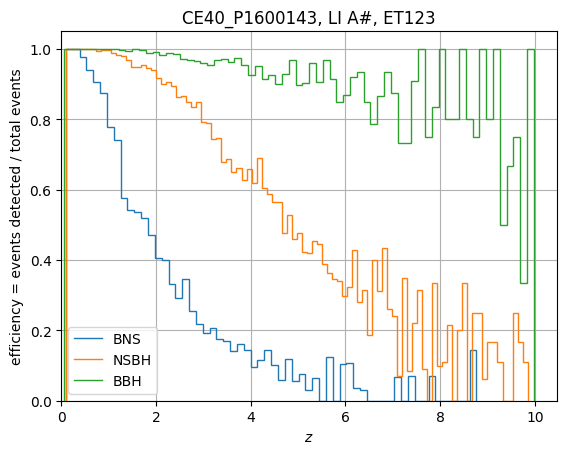

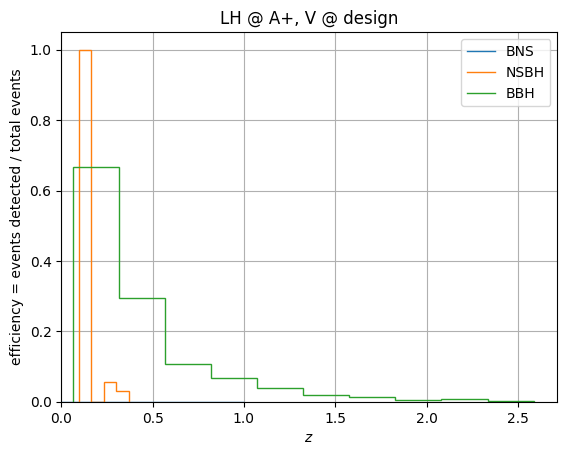

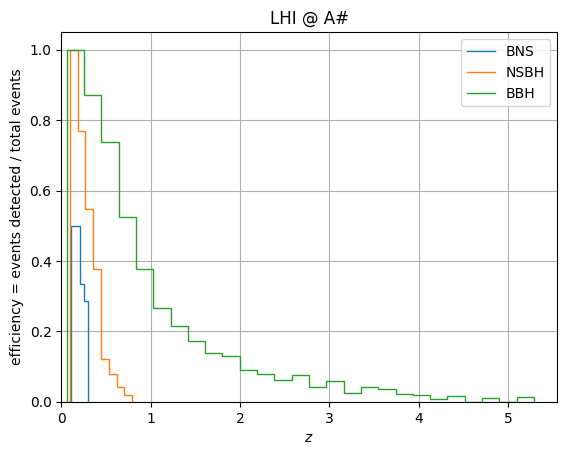

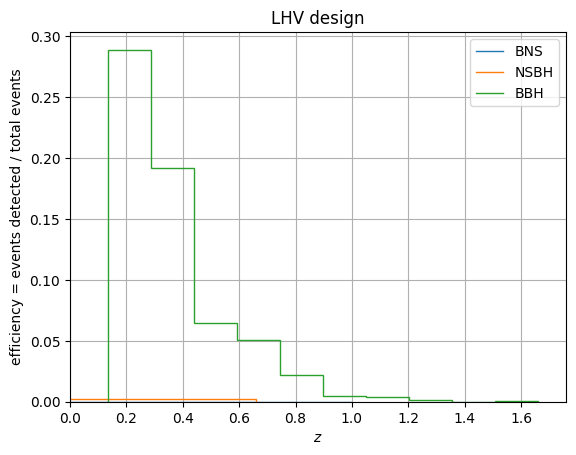

In [79]:
for netw in snr_data_bns.keys():
    plt.figure()
    for det_data, total_data, label in zip([detected_bns, detected_nsbh, detected_bbh], [snr_data_bns, snr_data_nsbh, snr_data_bbh], ['BNS', 'NSBH', 'BBH']):
        plot_efficiency_curve(det_data['network'][netw]['redshift'], 
                              total_data[netw]['redshift'], bins='auto', label=label, zorder=2)
    plt.legend()
    plt.xlim(0,)
    plt.grid()
    plt.xlabel('$z$')
    plt.ylabel('efficiency = events detected / total events')
    plt.title(netw_labels[netw])

/tmp/ipykernel_17358/1059002197.py:6: RuntimeWarning: invalid value encountered in divide
  eff_samples = ns_sel/ns_tot


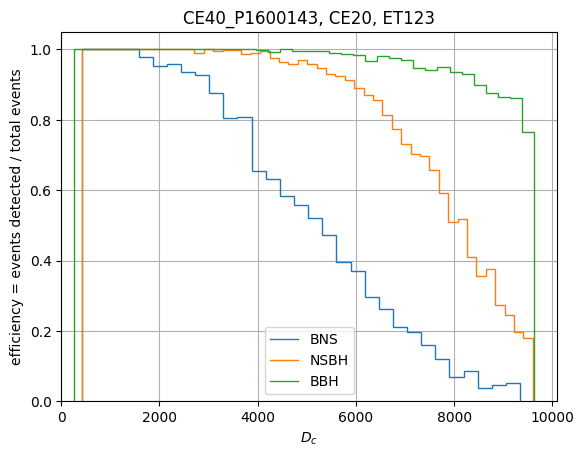

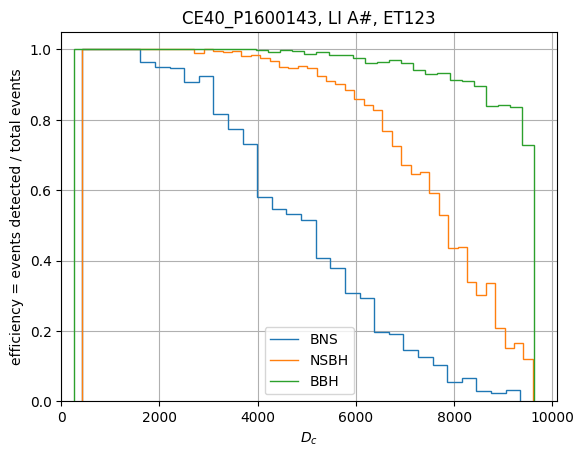

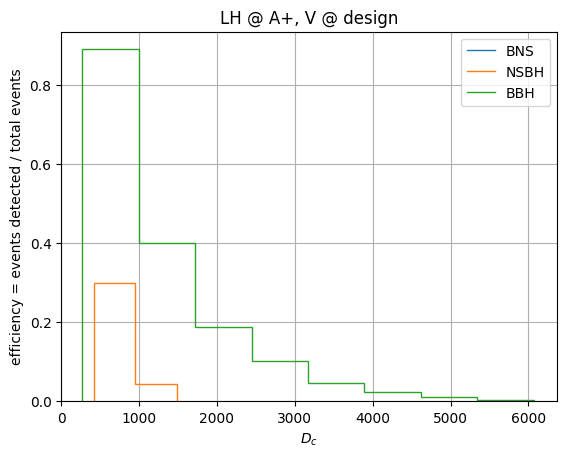

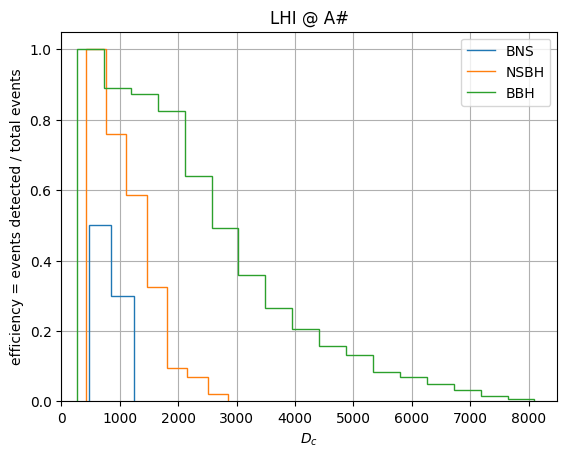

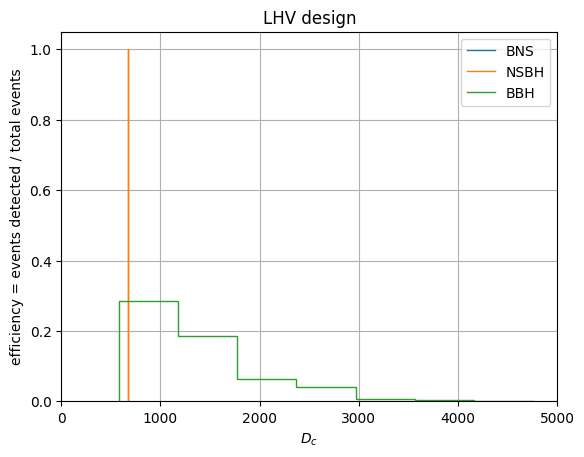

In [80]:
for netw in snr_data_bns.keys():
    plt.figure()
    for det_data, total_data, label in zip([detected_bns, detected_nsbh, detected_bbh], [snr_data_bns, snr_data_nsbh, snr_data_bbh], ['BNS', 'NSBH', 'BBH']):
        plot_efficiency_curve(det_data['network'][netw]['comoving_distance'], 
                              total_data[netw]['comoving_distance'], bins='scott', label=label, zorder=2)
    plt.legend()
    plt.xlim(0,)
    plt.grid()
    plt.xlabel('$D_c$')
    plt.ylabel('efficiency = events detected / total events')
    plt.title(netw_labels[netw])

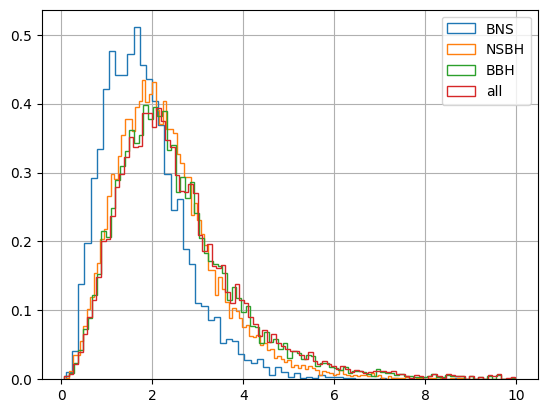

In [81]:
plt.hist(detected_bns['network']['CE40_P1600143_LIAsharpET123']['redshift'], histtype=u'step', bins='sqrt', density=True, label='BNS');
plt.hist(detected_nsbh['network']['CE40_P1600143_LIAsharpET123']['redshift'], histtype=u'step', bins='sqrt', density=True, label='NSBH');
plt.hist(detected_bbh['network']['CE40_P1600143_LIAsharpET123']['redshift'], histtype=u'step', bins='sqrt', density=True, label='BBH');
plt.hist(snr_data_bbh['CE40_P1600143_LIAsharpET123']['redshift'], histtype=u'step', bins='sqrt', density=True, label='all');
plt.grid()
plt.legend()